# Percentage signal change

---

Taken from the supplementary material of Cyril Pernet's article on GLM misconceptions

> **Misconceptions in the use of the General Linear Model applied to functional MRI: a tutorial for junior neuro-imagers.** Front. Neurosci., 21 January 2014, https://doi.org/10.3389/fnins.2014.00001

---

This Matlab code, is a simple demonstration of how to compute percentage
signal change using the GLM parameter estimates. 
It also compares this approach to computing the PSC from the modelled data.

Cyril Pernet v1 5 April 2013 // v2 1 Octobre 2013 for edits and PSC on modelled data

In [2]:
% when running localy
path_to_spm = '/home/remi/matlab/SPM/spm12/';
addpath(path_to_spm)

error: 'spm_get_bf' undefined near line 1 column 7
error: 'spm_hrf' undefined near line 3 column 15
error: 'SS' undefined near line 1 column 7
error: 'spm_hrf' undefined near line 1 column 15
error: operator *: nonconformant arguments (op1 is 1x500, op2 is 400x1)
error: 'beta1' undefined near line 1 column 13
error: X1(_,2): but X1 has size 500x1
error: 'Yhat' undefined near line 1 column 6
error: 'Yhat' undefined near line 2 column 17
error: 'Yhat' undefined near line 1 column 18
error: 'Residuals' undefined near line 1 column 16
error: 'SSeffect' undefined near line 1 column 6
error: 'SSeffect' undefined near line 1 column 6
error: 'F' undefined near line 1 column 22
error: 'R2' undefined near line 1 column 49
error: 'mytitle' undefined near line 1 column 7
error: operator -: nonconformant arguments (op1 is 400x400, op2 is 500x500)
error: 'R' undefined near line 1 column 14
error: 'beta1' undefined near line 1 column 14
error: 'T_con' undefined near line 1 column 27
error: 'beta1' un

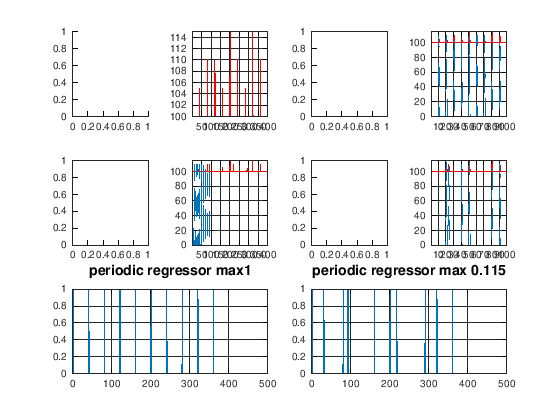

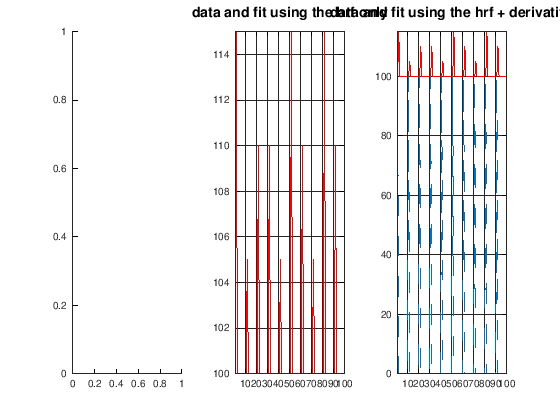

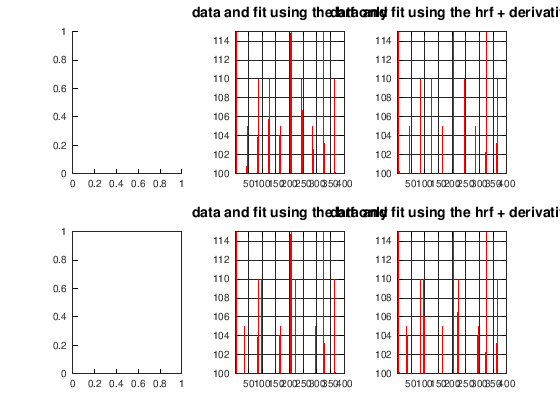

In [1]:
clear all;

% hrf model using SPM function
% ---------------------------
xBF.dt = 0.5;
xBF.name = 'hrf (with time derivative)';
xBF.length = 32;
xBF.order = 1;
xBF = spm_get_bf(xBF);

%% Simulate a Periodic design
% ------------------------

% create a hrf = brain response and scale
scale = [15 5 10 10 5 15 10 5 15 10];

% create a periodic design
% ------------------------
onsets = 1:40:400;
Y1 = zeros(500, 1); % 250 sec sample at 2Hz
X1 = zeros(500, 1);
for i = 1:10
    Y1(onsets(i)) = scale(i);
    X1(onsets(i)) = 1;
end

%%% _PSC from GLM parameters for the original data_
% --------------------------------------------------
SS = conv(X1, spm_hrf(0.5));
X1 = [SS(1:400) ones(400, 1)];
Y1 = conv(Y1, spm_hrf(0.5));
Y1 = Y1(1:400) + 100;
Average_signal(1) = mean(Y1); % average of the time series
SStotal = norm(Y1 - mean(Y1)).^2;
beta1 = pinv(X1) * Y1;
Yhat = X1 * beta1;

% start the figure
figure('Name', 'Fig. 6. Super sampled vs downsampled designs');
subplot(3, 4, 1);
imagesc([zscore(X1(:, 1)) X1(:, 2)]);
colormap('gray');
subplot(3, 4, 2);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y1) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);

mytitle = sprintf('R^2=%g \n F(%g,%g)=%g p=%g', R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1);
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X1));
C = [1 0];
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X1)));

% -------------------------
% percentage signal change
% -------------------------
% since all events have the same size, we can take the max as SF
myrange(1) = max(X1(:, 1));
PSC1 = beta1(1) * max(X1(:, 1)) ./ beta1(2) .* 100;
mytitle = sprintf('T=%g p=%g PSC=%g%%  \n', T_con, p_con, PSC1(1));
subplot(3, 4, 1);
title(mytitle, 'FontSize', 14);
subplot(3, 4, [9 10]);
plot(X1(:, 1), 'LineWidth', 3);
grid on;
title(['periodic regressor max' num2str(max(X1(:, 1)))], 'FontSize', 14);

% lets' compare with the SF being the 'standard' trial
% either use the height as SF
event = xBF.bf(:, 1);
PSC1b = beta1(1) * max(event) ./ beta1(2) .* 100;

% or use a model of the response - MarsBar style
scaled_event = event * beta1(1);
PSC_Yhat = max(scaled_event) / beta1(2) * 100;

% for comparison, compute PSC from for the original data
MY = reshape(Y1, 40, 10); % bin data per event
PSC_Y = mean(max(MY)) - 100; % 100 is the real baseline

% print output
% the small difference between real and modelled PSC comes from the
% constant beta1(2) which is estimated a little below 100 - note that for
% this simple periodic design, all estimates are the same
fprintf('PSC relative to baseline in the data = %g \n', PSC_Y);
fprintf('PSC using GLM parameters and SF from X = %g \n', PSC1);
fprintf('PSC using GLM parameters and SF from standard trial = %g \n', PSC1);
fprintf('PSC using modelled trial (MarsBaR) = %g \n', PSC_Yhat);

%%% _PSC from GLM parameters for downsampled data - as for real fMRI_
% --------------------------------------------------------------------
X1 = X1(1:4:400, :); % downsample
Y1 = Y1(1:4:400);   % downsample
Average_signal(2) = mean(Y1);
SStotal = norm(Y1 - mean(Y1)).^2;

beta1 = pinv(X1) * Y1;
Yhat = X1 * beta1;
subplot(3, 4, 3);
imagesc([zscore(X1(:, 1)) X1(:, 2)]);
colormap('gray');
subplot(3, 4, 4);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y1) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('R^2=%g \n F(%g,%g)=%g p=%g', R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1); % H matrix
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X1));
C = [1 0]; % contrast for condition 2 > condition 1
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C')); % T value
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X1)));

% -------------------------
% percentage signal change
% -------------------------
% for direct comparison of the effect of sampling, and all events still have
% the same height, let's take the max
myrange(2) = max(X1(:, 1));
PSC(1) = beta1(1) * max(X1(:, 1)) ./ beta1(2) .* 100; % scaling using downsampled design

% as before, compare with SF taken from the super sampled standard trial
myrange(3) = max(event);
PSC(2) = beta1(1) * max(event) ./ beta1(2) .* 100;
mytitle = sprintf('T=%g p=%g PSC=%g%% \n PSC using original X=%g%%', T_con, p_con, PSC(1), PSC(2));
subplot(3, 4, 3);
title(mytitle, 'FontSize', 14);

% or even compare with the modelled version (MarsBar style)
scaled_event = event * beta1(1);
PSC_Yhat = max(scaled_event) / beta1(2) * 100;

% print out the results
fprintf('PSC using GLM parameters from downsampled design = %g \n', PSC(1));
fprintf('PSC using GLM parameters from downsampled deisgn but with the SF from the standard trial= %g \n', PSC(2));
fprintf('PSC using modelled trial (MarsBaR) = %g \n', PSC_Yhat);

%% Fast event related design modelling the same 'brain responses' as before
% ------------------------------------------------------------------------
onsets = [1 31 81 93 161 201 218 291 321 361];
Y2 = zeros(500, 1); % 250 sec sample at 2Hz
X2 = zeros(500, 1);
for i = 1:10
    Y2(onsets(i)) = scale(i);
    X2(onsets(i)) = 1;
end

%%% _PSC from GLM parameters for the original data_
% --------------------------------------------------
SS = conv(X2, spm_hrf(0.5));
X2 = [SS(1:400) ones(400, 1)];
Y2 = conv(Y2, spm_hrf(0.5));
Y2 = Y2(1:400) + 100;
Average_signal(3) = mean(Y2);
SStotal = norm(Y2 - mean(Y2)).^2;

beta2 = pinv(X2) * Y2;
Yhat = X2 * beta2;
subplot(3, 4, 5);
imagesc([zscore(X2(:, 1)) X2(:, 2)]);
colormap('gray');
subplot(3, 4, 6);
plot(Y2, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y2 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X2) - 1;
dfe = length(Y2) - rank(X2);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('R^2=%g \n F(%g,%g)=%g p=%g \n', R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X2 * pinv(X2); % H matrix
R = eye(size(Y2, 1)) - P;
variance = ((R * Y2)' * (R * Y2)) / (size(Y2, 1) - rank(X2));
C = [1 0]; % contrast for condition 2 > condition 1
T_con = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C')); % T value
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y2, 1) - rank(X2)));

% -------------------------
% percentage signal change
% -------------------------
% what is happening if we use the SF from the current design
myrange(4) = max(SS);
PSC2    = beta2(1) .* max(SS) ./ beta2(2) .* 100;

% consider instred using the same SF across design, by taking the standard
% event height as SF
PSC2cor = beta2(1) .* max(event) ./ beta2(2) .* 100; % ie scale by max of a single event
mytitle = sprintf('T=%g p=%g PSC=%g%% \n PSC corrected=%g%% \n', T_con, p_con, PSC2(1), PSC2cor);
subplot(3, 4, 5);
title(mytitle, 'FontSize', 14);
subplot(3, 4, [11 12]);
plot(X2(:, 1), 'LineWidth', 3);
grid on;
title('periodic regressor max 0.115', 'FontSize', 14);

% do the same MarsBaR style - gives the same result
scaled_event = event * beta2(1);
PSC_Yhat = max(scaled_event) / beta2(2) * 100;

% finally, for compaison, get the PSC from for data
% get the max of event event
for e = 1:10
    index = onsets(e);
    if e < 10
        index2 = onsets(e + 1);
        max_Y2(e) = max(Y2(index:index2));
    else
        max_Y2(e) = max(Y2(index:end));
    end
end
PSC_Y = mean(max_Y2) - 100;

% print output
fprintf('PSC relative to baseline in the data = %g \n', PSC_Y);
fprintf('PSC using GLM parameters and SF from X = %g \n', PSC2);
fprintf('PSC using GLM parameters and SF from standard trial= %g \n', PSC2cor);
fprintf('PSC using modelled event (MarsBaR) = %g \n', PSC_Yhat);

%%% _PSC from GLM parameters for downsampled data - as for real fMRI_
% ------------------------------------------------------------------
X2 = X2(1:4:400, :);
Y2 = Y2(1:4:400);
Average_signal(4) = mean(Y2);
SStotal = norm(Y2 - mean(Y2)).^2;

beta2 = pinv(X2) * Y2;
Yhat = X2 * beta2;
subplot(3, 4, 7);
imagesc([zscore(X2(:, 1)) X2(:, 2)]);
colormap('gray');
subplot(3, 4, 8);
plot(Y2, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y2 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X2) - 1;
dfe = length(Y2) - rank(X2);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('R^2=%g \n F(%g,%g)=%g p=%g \n', R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X2 * pinv(X2); % H matrix
R = eye(size(Y2, 1)) - P;
variance = ((R * Y2)' * (R * Y2)) / (size(Y2, 1) - rank(X2));
C = [1 0]; % contrast for condition 2 > condition 1
T_con = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y2, 1) - rank(X2)));

% -------------------------
% percentage signal change
% -------------------------
% as before, what if we take SF from the current design
myrange(5) = max(X2(:, 1));
PSC2(1)    = beta2(1) .* max(X2(:, 1)) ./ beta2(2) .* 100;

% by comparison, use the SF from the Super Sampled design
myrange(6) = max(SS);
PSC2(2)    = beta2(1) ./ beta2(2) .* 100 .* max(SS); % max of the super sampled design

% now use the SF from the standard trial
PSC2cor = beta2(1) .* max(event) ./ beta2(2) .* 100;
mytitle = sprintf('T=%g p=%g PSC=%g%% \n PSC using original X=%g%% \n PSC corrected=%g%%', T_con, p_con, PSC2(1), PSC2(2), PSC2cor);
subplot(3, 4, 7);
title(mytitle, 'FontSize', 14);

% print output
fprintf('PSC using GLM parameters = %g \n', PSC2(1));
fprintf('PSC using GLM parameters but SF from the super sampled design = %g \n', PSC2(2));
fprintf('PSC using GLM parameters but SF from the standard trial = %g \n', PSC2cor);

% final check
fprintf('Average values in each simulation %g %g %G %g \n', Average_signal(1), Average_signal(2), Average_signal(3), Average_signal(4));

% ----------------------------
% Treat for SPM users:
% It is easy to recreate the super-sampled design by 1 - loading a SPM.mat
% then 2. define the basis functions used bf = SPM.xBF.bf;
% VolteraValue = SPM.xBF.Volterra; and 3. read session-wise such as for a
% session s, we can retrieve onsets with U = spm_get_ons(SPM,s); and get
% the super sampled design with [X,Xn,Fc] = spm_Volterra(U,bf,VolteraValue);
%
% To get the SF from the standard trial simply get the basis function(s)
% xBF.dt = SPM.xBF.dt;
% xBF.name = SPM.xBF.name;
% xBF.length = SPM.xBF.length;
% xBF.order = SPM.xBF.order;
% xBF = spm_get_bf(xBF);
% SF = max(xBF.bf(:,1));
% ----------------------------

%% Replicate the analyses adding a temporal shift in the data and the temporal derivative to the model

clear all;

% hrf model using SPM function
% ---------------------------
xBF.dt = 0.5;
xBF.name = 'hrf (with time derivative)';
xBF.length = 32;
xBF.order = 1;
xBF = spm_get_bf(xBF);

%%% *Periodic design*
% -------------------
% create a hrf = brain response and scale
scale = [15 5 10 10 5 15 10 5 15 10];

onsets = 1:40:400;
Y1 = zeros(500, 1);
X1 = zeros(500, 1);
for i = 1:10
    Y1(onsets(i) + 4) = scale(i);
    X1(onsets(i)) = 1;
end
Y1 = conv(Y1, spm_hrf(0.5));
Y1 = Y1(1:400) + 100;
SS(:, 1) = conv(X1, xBF.bf(:, 1));
SS(:, 2) = conv(X1, xBF.bf(:, 2));
x = spm_orth2(SS);
X1 = [x(1:400, :) ones(400, 1)];
Average_signal(1) = mean(Y1);
SStotal = norm(Y1 - mean(Y1)).^2;

beta1 = pinv(X1) * Y1;
Yhat = X1 * beta1;
figure('Name', 'Fig. 7. PSC using the 1st derivative');
subplot(2, 3, 1);
imagesc([zscore(X1(:, 1:2)) X1(:, 2)]);
colormap('gray');
subplot(2, 3, 2);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(X1(:, [1 3]) * beta1([1 3]), '--g', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf only', 'Fontsize', 14);
subplot(2, 3, 3);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf + derivative', 'Fontsize', 14);

% -------------------------
% percentage signal change
% -------------------------
% if we do as before using hrf only
event = xBF.bf(:, 1);
PSC1 = beta1(1) * max(event) ./ beta1(3) .* 100;

% but since we have a temporal derivative we can combine the bf
combined_event = xBF.bf(:, [1 2]) * [1 1]';
H = (sqrt(((beta1(1)^2) * sum(X1(:, 1).^2)) + ((beta1(2)^2) * sum(X1(:, 2).^2)))) * sign(beta1(1));
PSC1cor = H * max(combined_event) ./ beta1(3) .* 100;
mytitle = sprintf('PSC=%g%%  \n PSC adjusted=%g%%', PSC1, PSC1cor);
subplot(2, 3, 1);
title(mytitle, 'FontSize', 14);

% do the same MarsBaR style - gives different
event = xBF.bf(:, 1);
scaled_event = event * beta1(1);
deriv = xBF.bf(:, 2);
scaled_deriv = deriv * beta1(2);
PSC_Yhat = max(scaled_event + scaled_deriv) / beta1(3) * 100;

% for comparison compute PSC in the data
% bin data per event
MY = reshape(Y1, 40, 10);
PSC_Y = mean(max(MY)) - 100; % 100 is the real baseline

% print output
% the MarsBaR approach assumes the hrf regressor is fine, but in fact it is
% biased (see Cahloun et al. 2004) hence the discrepency
fprintf('PSC in the data relative to baseline = %g \n', PSC_Y);
fprintf('PSC using GLM hrf information only = %g \n', PSC1);
fprintf('PSC using GLM parameters combined= %g \n', PSC1cor);
fprintf('PSC using modelled event (MarsBaR) = %g \n', PSC_Yhat);

%%% _Fast event related with the same 'brain responses'_
% ------------------------------------------------------
clear SS;
onsets = [1 31 81 93  161 201 218 291 321 361];
Y2 = zeros(500, 1); % 250 sec sample at 2Hz
X2 = zeros(500, 1);
for i = 1:10
    Y2(onsets(i) + 4) = scale(i);
    X2(onsets(i)) = 1;
end
Y2 = conv(Y2, spm_hrf(0.5));
Y2 = Y2(1:400) + 100;
SS(:, 1) = conv(X2, xBF.bf(:, 1));
SS(:, 2) = conv(X2, xBF.bf(:, 2));
x = spm_orth2(SS);
X2 = [x(1:400, :) ones(400, 1)];

beta2 = pinv(X2) * Y2;
Yhat = X2 * beta2;
subplot(2, 3, 4);
imagesc([zscore(X2(:, 1:2)) X2(:, 2)]);
colormap('gray');
subplot(2, 3, 5);
plot(Y2, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(X2(:, [1 3]) * beta2([1 3]), '--g', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf only', 'Fontsize', 14);
subplot(2, 3, 6);
plot(Y2, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf + derivative', 'Fontsize', 14);

% -------------------------
% percentage signal change
% -------------------------
% use hrf only
PSC2 = beta2(1) .* max(event) ./ beta2(3) .* 100;

% use hrf and derivative
H  = (sqrt(((beta2(1)^2) * sum(X2(:, 1).^2)) + ((beta2(2)^2) * sum(X2(:, 2).^2)))) * sign(beta2(1));
PSC2cor = H * max(combined_event) ./ beta2(3) .* 100;
mytitle = sprintf('PSC=%g%%  \n PSC adjusted=%g%%', PSC2, PSC2cor);
subplot(2, 3, 4);
title(mytitle, 'FontSize', 14);

% do the same MarsBaR style - gives the same result
scaled_event = event * beta2(1);
scaled_deriv = deriv * beta2(2);
PSC_Yhat = max(scaled_event + scaled_deriv) / beta2(3) * 100;

% compute PSC from the data
% get the max of event event
for e = 1:10
    index = onsets(e);
    if e < 10
        index2 = onsets(e + 1) + 4;
        max_Y2(e) = max(Y2(index:index2));
    else
        max_Y2(e) = max(Y2(index:end));
    end
end
PSC_Y = mean(max_Y2) - 100;

% print output
fprintf('PSC in the data relative to baseline = %g \n', PSC_Y);
fprintf('PSC using GLM hrf information only = %g \n', PSC2);
fprintf('PSC using GLM parameters combined= %g \n', PSC2cor);
fprintf('PSC using modelled event (MarsBaR) = %g \n', PSC_Yhat);

%%% _test as well by downsampling_
% --------------------------------
onsets = 1:40:400;
Y1 = zeros(500, 1); % 250 sec sample at 2Hz
X1 = zeros(500, 1);
for i = 1:10
    Y1(onsets(i) + 4) = scale(i);
    X1(onsets(i)) = 1;
end
Y1 = conv(Y1, spm_hrf(0.5));
Y1 = Y1(1:400) + 100;
SS(:, 1) = conv(X1, xBF.bf(:, 1));
SS(:, 2) = conv(X1, xBF.bf(:, 2));
x = spm_orth2(SS);
X1 = [x(1:400, :) ones(400, 1)];
x1 = X1(1:4:400, :);
y1 = Y1(1:4:400);

beta1 = pinv(x1) * y1;
Yhat = x1 * beta1;
figure;
subplot(1, 3, 1);
imagesc([zscore(x1(:, 1:2)) x1(:, 2)]);
colormap('gray');
subplot(1, 3, 2);
plot(y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(x1(:, [1 3]) * beta1([1 3]), '--g', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf only', 'Fontsize', 14);
subplot(1, 3, 3);
plot(y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;
title('data and fit using the hrf + derivative', 'Fontsize', 14);

% PSC - also need to work with the upsampled design
% use hrf information only
PSC1 = beta1(1) * max(event) ./ beta1(3) .* 100;

% use hrf and derivative
H  = (sqrt(((beta1(1)^2) * sum(X1(:, 1).^2)) + ((beta1(2)^2) * sum(X1(:, 2).^2)))) * sign(beta1(1));
PSC1cor = H * max(combined_event) ./ beta1(3) .* 100;
mytitle = sprintf('PSC=%g%%  \n PSC adjusted=%g%%', PSC1, PSC1cor);
subplot(1, 3, 1);
title(mytitle, 'FontSize', 14);
